# Exploration, Enhancement, Visualization of Chicago Rideshare Dataset


## Step 1:  Import

In [1]:
%config IPCompleter.greedy=True

In [2]:
import csv
import os
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import seaborn as sns
import contextily as ctx #for basemaps
import requests

In [3]:
%%time
#Get data - either sample 12 GB file or load pre-sampled data
datadir=r'/Users/rtaylor/Desktop/Springboard/DataSets/Rideshare'
firstrun=False#False #set to true to reimport dataset from csv
if firstrun:
    iterdf=pd.read_csv(os.path.join(datadir,'Transportation_Network_Providers_-_Trips.csv'),chunksize=200000)
    #dataset has 40 million records
    samp_df=pd.DataFrame()
    #sample 5% of df and make new df
    for chunk in iterdf:
        samp_df=samp_df.append(chunk.sample(frac=0.05)) #5% of rides
    samp_df=samp_df.dropna(how='any')
    samp_df.columns = ['TripID', 'TripStart', 'TripEnd', 'TripSeconds',
           'TripMiles', 'PUCensusTract', 'DOCensusTract',
           'PUCommunityArea', 'DOCommunityArea', 'Fare', 'Tip',
           'AdditionalCharges', 'TripTotal', 'SharedTripAuth',
           'TripsPooled', 'PU_Lat', 'PU_Long','PU_Geo', 'DO_Lat',
           'DO_Long', 'DO_Geo'] #PU=pick up, DO=drop off
    samp_df['TripStart']=pd.to_datetime(samp_df['TripStart'],infer_datetime_format=True)
    samp_df['TripEnd']=pd.to_datetime(samp_df['TripEnd'],infer_datetime_format=True)
    samp_df.head()
    #this took a long time, saving output
    samp_df.to_pickle(os.path.join(datadir,'chicago_pickle_05'))
else:
    samp_df=pd.read_pickle(os.path.join(datadir,'chicago_pickle_05')) 

CPU times: user 665 ms, sys: 602 ms, total: 1.27 s
Wall time: 1.64 s


In [4]:
#inspect raw import
samp_df.iloc[:2,:15]


,TripID,TripStart,TripEnd,TripSeconds,TripMiles,PUCensusTract,DOCensusTract,PUCommunityArea,DOCommunityArea,Fare,Tip,AdditionalCharges,TripTotal,SharedTripAuth,TripsPooled
133854,b7d58e1e960991c5782a106372dde8a461280832,2018-11-23 19:00:00,2018-11-23 19:15:00,1009.0,4.5,1.703124e+10,1.703183e+10,24.0,6.0,10.0,0.0,2.5,12.5,False,1
68868,b6027701346eab0f8b86fd4a4b109822a378c791,2018-12-19 19:45:00,2018-12-19 20:00:00,860.0,3.1,1.703184e+10,1.703107e+10,32.0,7.0,7.5,0.0,2.5,10.0,False,1


## Wrangling
* Convert census tract from float to string
* Round datetime fields to nearest hour
* Aggregate by tract, datetime and compute total ride counts and average fare/dist/duration
* Create fields for DOW, Month, Hour

In [ ]:
#convert census tract fields from float to string
samp_df['PUCensusTract']=samp_df.PUCensusTract.astype(int).astype(str)
samp_df['DOCensusTract']=samp_df.DOCensusTract.astype(int).astype(str)


In [6]:
#round times to nearest hour
samp_df['TripStart']=samp_df.TripStart.dt.round('H')
samp_df['TripEnd']=samp_df.TripEnd.dt.round('H')

In [7]:
#group by tract and trip start time
grp_df=samp_df.groupby(['PUCensusTract','TripStart'])['Fare','Tip','AdditionalCharges','TripTotal','TripMiles','TripSeconds']
agg_avg=grp_df.mean()
agg_count=grp_df.size() 
agg_count=agg_count.rename('NumRides')
agg_df=agg_avg.join(agg_count) #join averages and count fields

In [8]:
#derive time fields
agg_df['StartTime2']=agg_df.index.get_level_values(level=1)
agg_df['Year']=agg_df.StartTime2.dt.year
agg_df['Month']=agg_df.StartTime2.dt.month
agg_df['DOW']=agg_df.StartTime2.dt.dayofweek
agg_df['Hour']=agg_df.StartTime2.dt.hour
agg_df=agg_df.drop('StartTime2',axis=1)

In [9]:
#inspct aggregated DF
agg_df.head()

Fare  Tip  AdditionalCharges  TripTotal  \
PUCensusTract TripStart                                                       
17031010100   2018-11-01 07:00:00   0.00  0.0                2.5       2.50   
              2018-11-01 16:00:00   5.00  0.0                2.5       7.50   
              2018-11-02 07:00:00  11.25  0.0                2.5      13.75   
              2018-11-02 15:00:00   7.50  0.0                0.0       7.50   
              2018-11-02 16:00:00   7.50  0.0                2.5      10.00   

                                   TripMiles  TripSeconds  NumRides  Year  \
PUCensusTract TripStart                                                     
17031010100   2018-11-01 07:00:00       0.50        111.0         1  2018   
              2018-11-01 16:00:00       1.90        683.5         2  2018   
              2018-11-02 07:00:00       5.75       1005.5         2  2018   
              2018-11-02 15:00:00       1.80        548.0         1  2018   
              2018-11-02 16:00:00       3.20        900.0         1  2018   

                                   Month  DOW  Hour  
PUCensusTract TripStart                              
17031010100   2018-11-01 07:00:00     11    3     7  
              2018-11-01 16:00:00     11    3    16  
              2018-11-02 07:00:00     11    4     7  
              2018-11-02 15:00:00     11    4    15  
              2018-11-02 16:00:00     11    4    16

## Merge additional datasets
### Import weather data (downloaded from NOAA) and join to rideshare data

In [10]:
weathcsv='/Users/rtaylor/Desktop/Springboard/DataSets/Climate/ChicagoMidway.csv'
weath_df=pd.read_csv(weathcsv)
weath_df.index=pd.DatetimeIndex(weath_df.DATE)
del weath_df['DATE']

#extract daily records (may not need)
weath_daily=weath_df.loc[weath_df.DailyAverageDryBulbTemperature.notnull(),['DailyAverageDryBulbTemperature','DailyAverageWindSpeed','DailyPrecipitation']]
weath_daily.columns=['DTemp','DWind','DPrecip']
weath_daily['DTemp']=pd.to_numeric(weath_daily['DTemp'],errors='coerce').fillna(method='ffill')
weath_daily['DPrecip']=pd.to_numeric(weath_daily['DPrecip'],errors='coerce').fillna(0)
weath_daily.index=weath_daily.index.normalize()
weath_daily.head()

#extract hourly records
weath_hourly=weath_df.loc[weath_df.HourlyDryBulbTemperature.notnull(),['HourlyDryBulbTemperature','HourlyWindSpeed','HourlyPrecipitation']]
weath_hourly.columns=['HTemp','HWind','HPrecip']
weath_hourly['HTemp']=pd.to_numeric(weath_hourly['HTemp'],errors='coerce').fillna(method='ffill') #check to see if these should have been interpolated instead
weath_hourly['HPrecip']=pd.to_numeric(weath_hourly['HPrecip'],errors='coerce').fillna(0)
weath_hourly['HWind']=pd.to_numeric(weath_hourly['HWind'],errors='coerce').fillna(0)
weath_hourly['Precip']=weath_hourly.HPrecip.apply(lambda x: 'Wet' if x>0.01 else 'Dry')

/Users/rtaylor/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (35,36,52,56,58,59,71,119) have mixed types. Specify dtype option on import or set low_memory=False.



In [11]:
weath_hourly.head()

,HTemp,HWind,HPrecip,Precip
DATE,,,,
2018-10-01 00:53:00,59.0,9.0,0.0,Dry
2018-10-01 01:53:00,59.0,11.0,0.0,Dry
2018-10-01 02:53:00,58.0,13.0,0.0,Dry
2018-10-01 03:00:00,58.0,13.0,0.0,Dry
2018-10-01 03:53:00,58.0,8.0,0.0,Dry


In [12]:
#use asof merge to join weather to hourly rides
agg_df_reindex=agg_df.reset_index().sort_values('TripStart')
agg_df_weather=pd.merge_asof(agg_df_reindex,weath_hourly,left_on='TripStart',right_index=True)
agg_df_weather=agg_df_weather.sort_values(['PUCensusTract','TripStart']).set_index(['PUCensusTract','TripStart'])

(737060.0, 737088.0)

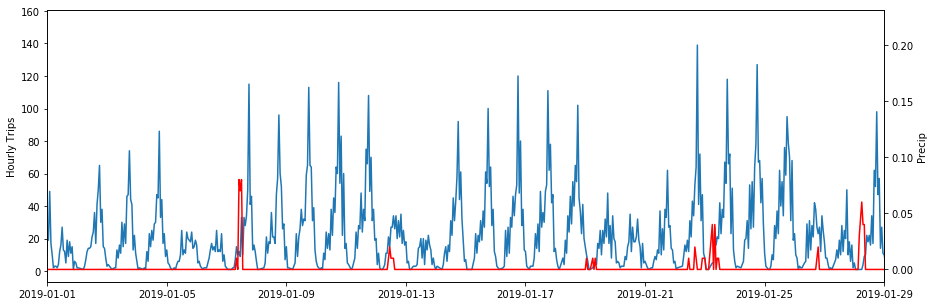

In [13]:
#look at data from one tract concurrently with precip
onetract=agg_df_weather.loc['17031839100']
fig,ax=plt.subplots(figsize=(15,5))
ax.plot(onetract.index,onetract['NumRides'])
ax2 = ax.twinx() 
ax2.plot(onetract.index,onetract.HPrecip,color='r')
ax.set_ylabel('Hourly Trips')
ax2.set_ylabel('Precip')
ax.set_xlim([pd.to_datetime('2019-01-01 00:00:00'), pd.to_datetime('2019-01-29 00:00:00')])

In [14]:
#is there a change in rides due to weather?
#possible increase in ride frequency, decrease in average distance/duration in rain/snow
agg_df_weather.groupby('Precip')['Fare','NumRides','TripMiles','TripSeconds'].describe().transpose()

Precip                       Dry           Wet
Fare        count  522190.000000  19430.000000
            mean        9.254040      9.344469
            std         5.598498      5.866149
            min         0.000000      0.000000
            25%         5.000000      5.500000
            50%         7.500000      7.500000
            75%        10.833333     10.833333
            max       180.000000     92.500000
NumRides    count  522190.000000  19430.000000
            mean        2.840003      3.102779
            std         4.548250      4.818555
            min         1.000000      1.000000
            25%         1.000000      1.000000
            50%         1.000000      1.000000
            75%         3.000000      3.000000
            max       153.000000     93.000000
TripMiles   count  522190.000000  19430.000000
            mean        4.705945      4.545463
            std         3.727446      3.643169
            min         0.000000      0.000000
            25%         2.300000      2.200000
            50%         3.600000      3.491608
            75%         5.850000      5.566667
            max        98.700000     37.400000
TripSeconds count  522190.000000  19430.000000
            mean      978.814074    973.341400
            std       594.922983    611.437359
            min         0.000000      3.000000
            25%       591.000000    583.500000
            50%       844.500000    827.500000
            75%      1223.444444   1200.660714
            max     72420.000000   9297.000000

### Join in Census Tract Geodata to enable mapping
Census data comes at various levels of aggregation.
The rideshare data is grouped at the census tract level.
Census tract >  block group > block 

In [15]:
censtracts=gpd.read_file(os.path.join(datadir,'Boundaries - Census Tracts - 2010.geojson'))
censtracts=censtracts.set_index('geoid10')

In [16]:
#which census tracts are the largest overall source of rider pickups?
usage=samp_df.groupby('PUCensusTract').size()
usage=usage.rename('usage')

/Users/rtaylor/anaconda3/lib/python3.7/site-packages/contextily/tile.py:199: FutureWarning:

The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.



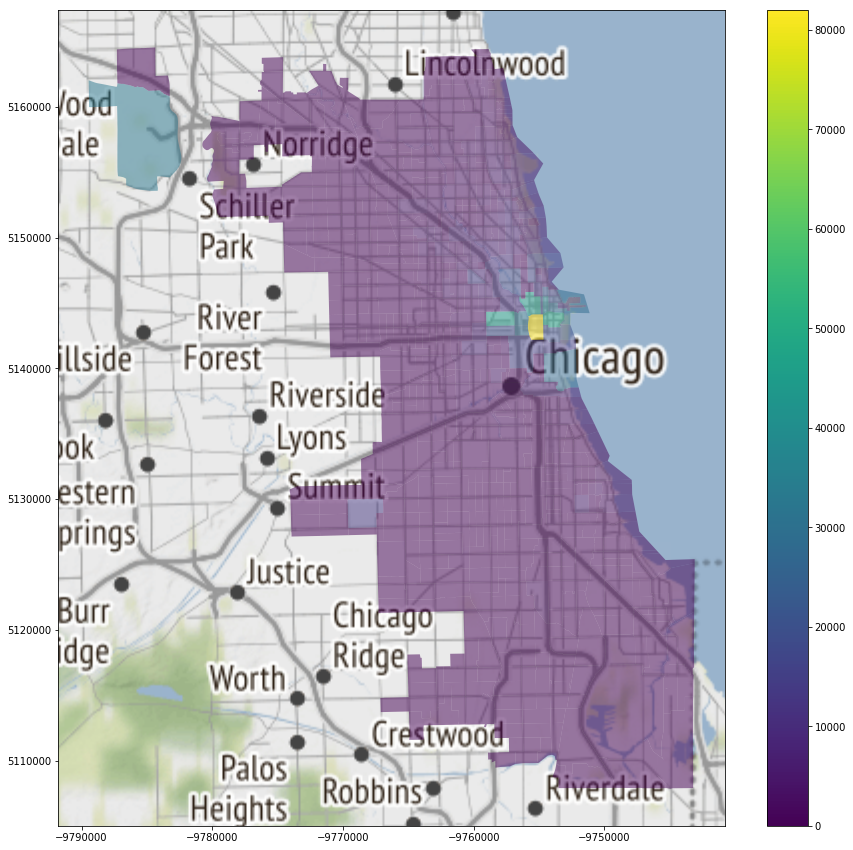

In [17]:
#join usage to census geo
usage_by_census_geo=censtracts.join(usage,how='left')
usage_by_census_geo['usage']=usage_by_census_geo['usage'].fillna(0)
usage_by_census_geo= usage_by_census_geo.to_crs(epsg=3857) #convert wgs84 to wms

#function copied from geopandas documentation
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
fig,ax=plt.subplots(figsize=(15,15))
usage_by_census_geo.plot(column='usage',ax=ax,legend=True,alpha=0.5)
add_basemap(ax, zoom=10)

#generally, biggest ride sources are downtown and O'Hare airport

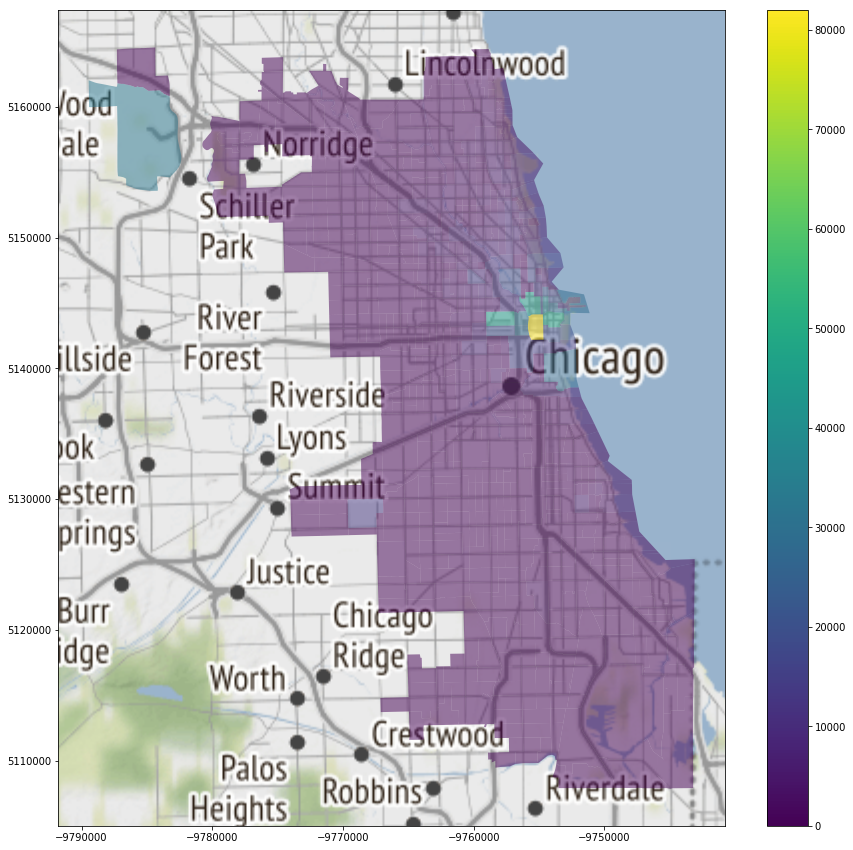

In [18]:
#Same analysis for destinations

#which census tracts are the largest overall rider destinations?
do_usage=samp_df.groupby('DOCensusTract').size()
do_usage=usage.rename('usage')
#join usage to census geo
do_usage_by_census_geo=censtracts.join(do_usage,how='left')
do_usage_by_census_geo['usage']=do_usage_by_census_geo['usage'].fillna(0)
do_usage_by_census_geo= do_usage_by_census_geo.to_crs(epsg=3857) #convert to wms
    
fig,ax=plt.subplots(figsize=(15,15))
do_usage_by_census_geo.plot(column='usage',ax=ax,legend=True,alpha=0.5)
add_basemap(ax, zoom=10)

#generally, biggest ride destinations are also downtown and O'Hare airport

### Use requests package to download census data by tract to merge into dataset

* median income
* total population (doesn't vary much, but needed to calculate population density)

In [28]:
key='17169eb9725df2ebdec38f4781f9b3e3f1ecd0b8' #my API key, please don't steal
url=r'https://api.census.gov/data/2017/acs/acs5?get=B19013_001E,B01003_001E,NAME&for=tract:*&in=state:17&key='+key
results=requests.get(url) #B19013 is median income, B01003 is population

In [55]:
rlst=results.json() #list of lists
cols=['MedIncome','Population']+rlst[0][2:]
censdf=pd.DataFrame.from_records(rlst[1:],columns=cols)
censdf['PUCensusTract']=censdf.apply(lambda row:  row.state+row.county+row.tract,axis=1)
censdf=censdf.drop(['state','county','tract'],axis=1)
censdf=censdf.set_index('PUCensusTract')

In [56]:
censdf.head()

,MedIncome,Population,NAME
PUCensusTract,,,
17197881002,88203,5186,"Census Tract 8810.02, Will County, Illinois"
17197881105,121463,6394,"Census Tract 8811.05, Will County, Illinois"
17197880502,85913,5180,"Census Tract 8805.02, Will County, Illinois"
17197883700,48516,3127,"Census Tract 8837, Will County, Illinois"
17197880105,90172,7590,"Census Tract 8801.05, Will County, Illinois"


In [67]:
agg_all=agg_df_weather.merge(censdf,left_on='PUCensusTract',right_index=True)
agg_all.head()

Fare  Tip  AdditionalCharges  TripTotal  \
            TripStart                                                       
17031010100 2018-11-01 07:00:00   0.00  0.0                2.5       2.50   
            2018-11-01 16:00:00   5.00  0.0                2.5       7.50   
            2018-11-02 07:00:00  11.25  0.0                2.5      13.75   
            2018-11-02 15:00:00   7.50  0.0                0.0       7.50   
            2018-11-02 16:00:00   7.50  0.0                2.5      10.00   

                                 TripMiles  TripSeconds  NumRides  Year  \
            TripStart                                                     
17031010100 2018-11-01 07:00:00       0.50        111.0         1  2018   
            2018-11-01 16:00:00       1.90        683.5         2  2018   
            2018-11-02 07:00:00       5.75       1005.5         2  2018   
            2018-11-02 15:00:00       1.80        548.0         1  2018   
            2018-11-02 16:00:00       3.20        900.0         1  2018   

                                 Month  DOW  Hour  HTemp  HWind  HPrecip  \
            TripStart                                                      
17031010100 2018-11-01 07:00:00     11    3     7   51.0   15.0      0.0   
            2018-11-01 16:00:00     11    3    16   48.0   21.0      0.0   
            2018-11-02 07:00:00     11    4     7   39.0    7.0      0.0   
            2018-11-02 15:00:00     11    4    15   48.0   11.0      0.0   
            2018-11-02 16:00:00     11    4    16   46.0    9.0      0.0   

                                Precip MedIncome Population  \
            TripStart                                         
17031010100 2018-11-01 07:00:00    Dry     33750       4444   
            2018-11-01 16:00:00    Dry     33750       4444   
            2018-11-02 07:00:00    Dry     33750       4444   
            2018-11-02 15:00:00    Dry     33750       4444   
            2018-11-02 16:00:00    Dry     33750       4444   

                                                                    NAME  
            TripStart                                                     
17031010100 2018-11-01 07:00:00  Census Tract 101, Cook County, Illinois  
            2018-11-01 16:00:00  Census Tract 101, Cook County, Illinois  
            2018-11-02 07:00:00  Census Tract 101, Cook County, Illinois  
            2018-11-02 15:00:00  Census Tract 101, Cook County, Illinois  
            2018-11-02 16:00:00  Census Tract 101, Cook County, Illinois

### compute population density by census tract

In [86]:
censtracts_utm=censtracts.to_crs({'init': 'epsg:26916'}) #convert to projected crs for area calc
censtracts_utm['area_sq_km']=censtracts_utm.geometry.area*1e-6 #convert sq m to km

In [92]:
censtracts_data_utm=censtracts_utm.join(censdf)
censtracts_data_utm['PopDensity']=censtracts_data_utm['Population'].astype('int')/censtracts_data_utm['area_sq_km']
censtracts_data_utm.head()

,statefp10,name10,commarea_n,namelsad10,commarea,notes,tractce10,countyfp10,geometry,area_sq_km,MedIncome,Population,NAME,PopDensity
geoid10,,,,,,,,,,,,,,
17031842400,17,8424,44,Census Tract 8424,44,,842400,031,(POLYGON ((448099.9853234108 4620011.369018904...,1.967197,39161,3084,"Census Tract 8424, Cook County, Illinois",1567.713190
17031840300,17,8403,59,Census Tract 8403,59,,840300,031,"(POLYGON ((443023.106000765 4630347.018746218,...",0.830626,48056,3917,"Census Tract 8403, Cook County, Illinois",4715.721491
17031841100,17,8411,34,Census Tract 8411,34,,841100,031,(POLYGON ((447758.9098946017 4633624.092255936...,1.142409,26905,6821,"Census Tract 8411, Cook County, Illinois",5970.716251
17031841200,17,8412,31,Census Tract 8412,31,,841200,031,(POLYGON ((442881.5617666839 4633982.840450388...,0.624955,36104,5183,"Census Tract 8412, Cook County, Illinois",8293.395759
17031839000,17,8390,32,Census Tract 8390,32,,839000,031,(POLYGON ((447463.3120691107 4636034.681641942...,0.516078,84347,8542,"Census Tract 8390, Cook County, Illinois",16551.763927


In [94]:
#is range of pop density reasonable?

censtracts_data_utm.describe()
#New york city is 10K people per square km, looks like there may be an outlier? 

,area_sq_km,PopDensity
count,801.000000,801.000000
mean,0.783002,6994.203453
std,1.251212,6095.851048
min,0.008293,0.000000
25%,0.325686,3710.902500
50%,0.537449,5808.404418
75%,0.869069,9071.885143
max,21.624324,118419.707546


In [98]:
#censtracts_data_utm.loc[censtracts_data_utm.PopDensity==censtracts_data_utm.PopDensity.max()]
censtracts_data_utm.sort_values('PopDensity',ascending=False).head() #census tract with super high density has very small area

,statefp10,name10,commarea_n,namelsad10,commarea,notes,tractce10,countyfp10,geometry,area_sq_km,MedIncome,Population,NAME,PopDensity
geoid10,,,,,,,,,,,,,,
17031030702,17,307.02,77,Census Tract 307.02,77,,030702,031,(POLYGON ((445729.2896994138 4647836.016301802...,0.008293,73967,982,"Census Tract 307.02, Cook County, Illinois",118419.707546
17031081100,17,811,8,Census Tract 811,8,,081100,031,(POLYGON ((447757.6513524652 4638588.837685242...,0.102274,72303,4077,"Census Tract 811, Cook County, Illinois",39863.391579
17031063302,17,633.02,6,Census Tract 633.02,6,,063302,031,(POLYGON ((447125.4052672551 4642877.647821395...,0.121111,74805,4140,"Census Tract 633.02, Cook County, Illinois",34183.557708
17031081600,17,816,8,Census Tract 816,8,,081600,031,"(POLYGON ((447768.658024789 4637669.510520778,...",0.132708,103060,3937,"Census Tract 816, Cook County, Illinois",29666.539316
17031063301,17,633.01,6,Census Tract 633.01,6,,063301,031,(POLYGON ((446592.4116972681 4642746.170877315...,0.093784,48906,2588,"Census Tract 633.01, Cook County, Illinois",27595.183255


In [19]:
#Which census tracts have the most pickups/dropoffs?
top10PU=samp_df.groupby('PUCensusTract').size().sort_values(ascending=False).index[:10].values #ndarray
top10DO=samp_df.groupby('DOCensusTract').size().sort_values(ascending=False).index[:10].values

In [20]:
topPU_DF=agg_df.query("PUCensusTract in @top10PU")



In [21]:
samp_df.shape


(1543308, 21)